# Remeshing

This notebook provides examples of triangular mesh adjustment operations, such as:
- decimation - reducing number of triangles
- tesselation - increasing number of triangles

The example uses GPU-accelerated algorithm described in [MicroMap Toolkit](https://github.com/NVIDIAGameWorks/Displacement-MicroMap-Toolkit) repository.

## Initialization

Download sample meshes from AhmedML and DrivAerML datasets.

In [1]:
%%bash
if [ ! -f "./assets/boundary_1_1M.vtp" ]; then
    mkdir -p ./assets
    wget "https://huggingface.co/datasets/neashton/ahmedml/resolve/main/run_1/boundary_1.vtp" -O "./assets/boundary_1_1M.vtp"
else
    echo "File already exists."
fi

if [ ! -f "./assets/boundary_1_10M.vtp" ]; then
    mkdir -p ./assets
    wget "https://huggingface.co/datasets/neashton/drivaerml/resolve/main/run_1/boundary_1.vtp" -O "./assets/boundary_1_10M.vtp"
else
    echo "File already exists."
fi

File already exists.
File already exists.


Import required packages.

In [2]:
from time import time

import numpy as np

import pyvista as pv

from physicsnemo.sym.geometry.tessellation import Tessellation

import micromesh_python as pymm

/usr/local/lib/python3.12/dist-packages/warp/codegen.py:2735: DeprecationWarning: ast.Str is deprecated and will be removed in Python 3.14; use ast.Constant instead
  ast.Str: emit_String,  # Deprecated in 3.8; use Constant
/usr/local/lib/python3.12/dist-packages/warp/codegen.py:2736: DeprecationWarning: ast.Num is deprecated and will be removed in Python 3.14; use ast.Constant instead
  ast.Num: emit_Num,  # Deprecated in 3.8; use Constant
/usr/local/lib/python3.12/dist-packages/warp/codegen.py:2737: DeprecationWarning: ast.NameConstant is deprecated and will be removed in Python 3.14; use ast.Constant instead
  ast.NameConstant: emit_NameConstant,  # Deprecated in 3.8; use Constant
/usr/local/lib/python3.12/dist-packages/warp/codegen.py:2754: DeprecationWarning: ast.Ellipsis is deprecated and will be removed in Python 3.14; use ast.Constant instead
  ast.Ellipsis: emit_Ellipsis,


Prepare sample data from the dataset.

In [3]:
# Set to True to use large 10M mesh.
use_10M_mesh = False
filename = "./assets/boundary_1_10M.vtp" if use_10M_mesh else "./assets/boundary_1_1M.vtp"

# Read the mesh from VTP file.
orig_mesh = pv.read(filename)

# The algorithm works only with tri-meshes.
tri_mesh = orig_mesh.triangulate()

In [4]:
# Print some stats.
#
from collections import Counter
from vtk import vtkCellTypes

def get_cell_type_name(cell_type_id: int) -> str:
    name = vtkCellTypes.GetClassNameFromTypeId(cell_type_id)
    return name if name else f"Unknown ({cell_type_id})"

cell_type_counts = {
    get_cell_type_name(k): v
    for k, v in Counter(
        orig_mesh.GetCellType(i) for i in range(orig_mesh.n_cells)
    ).items()
}

print(f"Original mesh:\n{orig_mesh}\nCell type counts:\n{cell_type_counts}\n")
print(f"Tri-mesh:\n{tri_mesh}")

Original mesh:
PolyData (0x7f92341f1720)
  N Cells:    1101574
  N Points:   1131049
  N Strips:   0
  X Bounds:   -1.188e+00, 2.168e-19
  Y Bounds:   -1.847e-01, 1.847e-01
  Z Bounds:   5.000e-02, 3.036e-01
  N Arrays:   5
Cell type counts:
{'vtkQuad': 1101164, 'vtkPolygon': 410}

Tri-mesh:
PolyData (0x7f92341f16c0)
  N Cells:    2203558
  N Points:   1131049
  N Strips:   0
  X Bounds:   -1.188e+00, 2.168e-19
  Y Bounds:   -1.847e-01, 1.847e-01
  Z Bounds:   5.000e-02, 3.036e-01
  N Arrays:   5


Initialize micromesh context.

In [5]:
context = pymm.createContext(verbosity=pymm.Verbosity.Info)

_______________
Vulkan Version:
 - available:  1.3.296
 - requesting: 1.3.0
______________________
Used Instance Layers :

Used Instance Extensions :
____________________
Devices : 3
0: NVIDIA TITAN RTX
  - Compatible 
1: NVIDIA GeForce RTX 3090
  - Compatible 
2: llvmpipe (LLVM 19.1.1, 256 bits)
  - Compatible 
Compatible physical devices found : 3
Using Device:
 - Device Name    : NVIDIA GeForce RTX 3090
 - Vendor         : NVIDIA
 - Driver Version : 535.732.64
 - API Version    : 1.3.242
 - Device Type    : Discrete GPU
________________________
Used Device Extensions :
VK_KHR_acceleration_structure
VK_KHR_ray_tracing_pipeline
VK_KHR_ray_query
VK_KHR_push_descriptor
VK_KHR_deferred_host_operations
VK_KHR_buffer_device_address
VK_EXT_memory_budget
VK_EXT_shader_atomic_float

Context created


## Remeshing

The following sections demonstrate how to use micro-mesh API to perform mesh decimation and tesselation.

### Utility functions

Functions to convert data between micro-mesh and VTK (PolyData) formats.

In [6]:
def create_mm_mesh(vertices: np.ndarray, triangles: np.ndarray) -> pymm.Mesh:
    """Creates micro-mesh Mesh given source mesh as vertices/triangles arrays."""
    assert vertices.ndim == 2 and vertices.shape[1] == 3, f"{vertices.shape = }"
    assert triangles.ndim == 2 and triangles.shape[1] == 3, f"{triangles.shape = }"

    mm_mesh = pymm.Mesh()
    mm_mesh.triangleVertices = triangles
    mm_mesh.vertexPositions = vertices

    return mm_mesh


def mm_mesh_to_polydata(src: pymm.Mesh) -> pv.PolyData:
    """Creates PolyData mesh given source micro-mesh Mesh."""

    # In PolyData, triangular faces are in [3, n0, n1, n2] format.
    num_triangles = np.full((src.triangleVertices.shape[0], 1), 3)
    faces = np.hstack((num_triangles, src.triangleVertices))

    return pv.PolyData(src.vertexPositions, faces)


def polydata_to_mm_mesh(src: pv.PolyData) -> pymm.Mesh:
    """Converts VTK PolyData to micro-mesher Mesh."""

    vertices = src.points
    triangles = np.reshape(src.faces, (-1, 4))
    assert (triangles[:, 0] == 3).all(), "Expected tri-mesh."
    # Remove vertex count, keep only indices.
    triangles = triangles[:, 1:]

    return create_mm_mesh(vertices, triangles)

### Decimation

Define and run mesh decimation.

In [7]:
def decimate(context, mm_mesh: pymm.Mesh, target_reduction: float = 0.5) -> pymm.Mesh:
    """Decimates source mesh given parameters."""

    remesher_settings = pymm.RemesherSettings()
    remesher_settings.decimationRatio = 1.0 - target_reduction
    remesher_settings.errorThreshold = 90
    remesher_settings.maxSubdivLevel = 4

    return pymm.remesh(context, mm_mesh, remesher_settings)


def warmup_data():
    """Small mesh used to warmup micromesher."""

    # 5 vertices (square with center), 4 triangles.
    vertices = np.array([
        [0, 0, 0],
        [1, 0, 0],
        [0, 1, 0],
        [1, 1, 0],
        [.5, .5, 0],
    ], dtype=np.float32)

    triangles = np.array([
        [0, 1, 4],
        [1, 3, 4],
        [3, 2, 4],
        [0, 2, 4],
    ], dtype=np.float32)

    return create_mm_mesh(vertices, triangles)

Run mesh decimation.

In [8]:
# Warmup.
decimate(context, warmup_data(), 0.9)

# GPU micromesh decimation.
target_reduction = 0.95

mm_mesh = polydata_to_mm_mesh(tri_mesh)
start = time()
decimated_mesh_gpu = decimate(context, mm_mesh, target_reduction=target_reduction)
elapsed_gpu = time() - start

start = time()
decimated_mesh_cpu = tri_mesh.decimate_pro(target_reduction)
elapsed_cpu = time() - start

  Triangles: 4 -> 4
Remeshing started 2203558 -> 110177 triangles max
Remeshing in progress 2203558 -> 2049292 triangles - 7.3% (511.01 ms)
Remeshing in progress 2203558 -> 1910136 triangles - 13.9% (613.27 ms)
Remeshing in progress 2203558 -> 1777432 triangles - 20.2% (713.36 ms)
Remeshing in progress 2203558 -> 1653954 triangles - 26.0% (810.25 ms)
Remeshing in progress 2203558 -> 1541244 triangles - 31.3% (903.33 ms)
Remeshing in progress 2203558 -> 1343276 triangles - 40.7% (1077.94 ms)
Remeshing in progress 2203558 -> 1176220 triangles - 48.6% (1237.67 ms)
Remeshing in progress 2203558 -> 1033652 triangles - 55.3% (1382.21 ms)
Remeshing in progress 2203558 -> 909784 triangles - 61.2% (1511.19 ms)
Remeshing in progress 2203558 -> 804538 triangles - 66.2% (1626.57 ms)
Remeshing in progress 2203558 -> 681994 triangles - 72.0% (1778.35 ms)
Remeshing in progress 2203558 -> 569858 triangles - 77.3% (1951.05 ms)
Remeshing in progress 2203558 -> 463030 triangles - 82.3% (2165.44 ms)
Remes

Report performance and visualize resulting meshes.

In [9]:
def report_perf(
    elapsed_gpu: float,
    elapsed_cpu: float,
    mesh_orig: pv.PolyData,
    mesh_gpu: pymm.Mesh,
    mesh_cpu: pv.PolyData
):
    from tabulate import tabulate

    headers = ["Device", "Time (sec)", "In faces", "Out faces"]
    data = [
        ["GPU", elapsed_gpu, mesh_orig.n_cells, mesh_gpu.triangleVertices.shape[0]],
        ["CPU", elapsed_cpu, mesh_orig.n_cells, mesh_cpu.n_cells],
    ]

    return tabulate(data, headers, tablefmt="github", intfmt=",", floatfmt=".2f")

print(report_perf(elapsed_gpu, elapsed_cpu, tri_mesh, decimated_mesh_gpu, decimated_mesh_cpu))

| Device   |   Time (sec) |   In faces |   Out faces |
|----------|--------------|------------|-------------|
| GPU      |         4.10 |  2,203,558 |     102,514 |
| CPU      |        10.60 |  2,203,558 |     110,176 |


Display nice side-by-side interactive plot to show the results of the decimation.

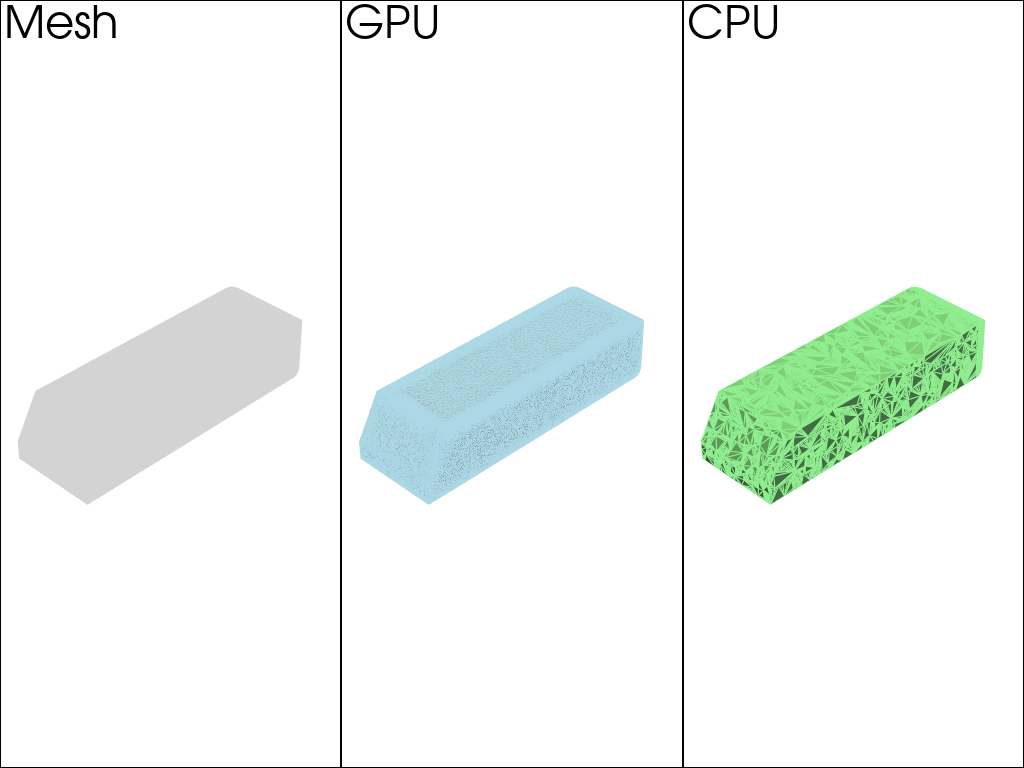

In [10]:
def plot_meshes(mesh_orig: pv.PolyData, mesh_gpu: pymm.Mesh, mesh_cpu: pv.PolyData):
    """Displays meshes."""

    plotter = pv.Plotter(shape=(1, 3))

    plotter.subplot(0, 0)
    plotter.add_mesh(mesh_orig, color="lightgrey", show_edges=True, edge_color="lightgrey")
    plotter.add_text("Mesh", position="upper_left")

    plotter.subplot(0, 1)
    plotter.add_mesh(mm_mesh_to_polydata(mesh_gpu), color="lightblue", show_edges=True, edge_color="lightblue")
    plotter.add_text("GPU", position="upper_left")

    plotter.subplot(0, 2)
    plotter.add_mesh(mesh_cpu, color="lightgreen", show_edges=True, edge_color="lightgreen")
    plotter.add_text("CPU", position="upper_left")

    plotter.show()

plot_meshes(tri_mesh, decimated_mesh_gpu, decimated_mesh_cpu)

### Tesselation

Run mesh tesselation.

In [11]:
# Tessellation class supports only STL files,
# so we need to convert the decimated mesh to STL first.
decimated_mesh_gpu_pd = mm_mesh_to_polydata(decimated_mesh_gpu)
print(decimated_mesh_gpu_pd)

stl_filename = "./assets/mesh.stl"
decimated_mesh_gpu_pd.save(stl_filename)
geometry = Tessellation.from_stl(stl_filename)

PolyData (0x7f922a48fdc0)
  N Cells:    102514
  N Points:   51259
  N Strips:   0
  X Bounds:   -1.188e+00, 3.858e-05
  Y Bounds:   -1.847e-01, 1.847e-01
  Z Bounds:   4.994e-02, 3.034e-01
  N Arrays:   0


Sample from STL using Tessellation class.

In [12]:
start = time()
samples = geometry.sample_boundary(1_800_000)
elapsed_cpu = time() - start
print(elapsed_cpu)
# Convert samples to VTK PolyData point cloud.
tess_mesh_cpu = pv.PolyData(np.hstack((samples["x"], samples["y"], samples["z"])))
print(tess_mesh_cpu)

Warp 1.6.2 initialized:
   CUDA Toolkit 12.8, Driver 12.2
   Devices:
     "cpu"      : "x86_64"
     "cuda:0"   : "NVIDIA GeForce RTX 3090" (24 GiB, sm_86, mempool enabled)
     "cuda:1"   : "NVIDIA TITAN RTX" (24 GiB, sm_75, mempool enabled)
   CUDA peer access:
     Not supported
   Kernel cache:
     /home/ubuntu/.cache/warp/1.6.2
Module physicsnemo.utils.sdf 36297e8 load on device 'cuda:0' took 0.40 ms  (cached)
13.210442304611206
PolyData (0x7f922a4cc820)
  N Cells:    1800000
  N Points:   1800000
  N Strips:   0
  X Bounds:   -1.188e+00, 2.476e-05
  Y Bounds:   -1.847e-01, 1.847e-01
  Z Bounds:   4.995e-02, 3.034e-01
  N Arrays:   0


In [13]:
def tesselate(
    context,
    mesh_orig: pymm.Mesh,
    max_subdiv_level: int = 4,
    edge_length_based: bool = True,
) -> pymm.Mesh:
    """Tesselates source mesh given parameters."""
    pretessellator_settings = pymm.PreTessellatorSettings()
    pretessellator_settings.maxSubdivLevel = max_subdiv_level
    pretessellator_settings.edgeLengthBased = edge_length_based

    low_mesh = pymm.Mesh()
    low_mesh.triangleVertices = mesh_orig.triangleVertices
    low_mesh.vertexPositions = mesh_orig.vertexPositions

    return pymm.preTessellate(context, low_mesh, pretessellator_settings)

start = time()
tess_mesh_gpu = tesselate(context, decimated_mesh_gpu)
elapsed_gpu = time() - start

Generating mesh attributes TriangleSubdivLevels|TrianglePrimitiveFlags|VertexNormals|VertexDirections
  Triangles: 1852826 -> 1852826


In [14]:
print(report_perf(elapsed_gpu, elapsed_cpu, decimated_mesh_gpu_pd, tess_mesh_gpu, tess_mesh_cpu))

| Device   |   Time (sec) |   In faces |   Out faces |
|----------|--------------|------------|-------------|
| GPU      |         0.19 |    102,514 |   1,852,826 |
| CPU      |        13.21 |    102,514 |   1,800,000 |


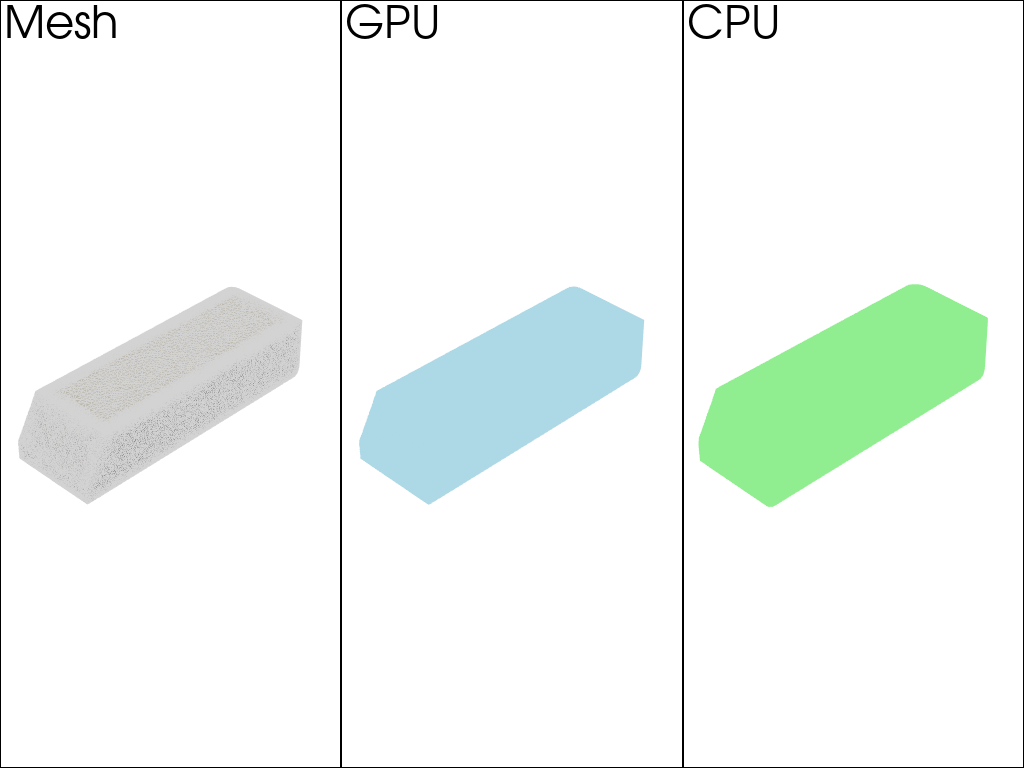

In [15]:
plot_meshes(decimated_mesh_gpu_pd, tess_mesh_gpu, tess_mesh_cpu)